# Exercise 14

## Predict rating using LSTM


In [178]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sb
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec, Phrases
from keras.preprocessing.sequence import pad_sequences
import livelossplot
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [179]:
dataTraining = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)

In [180]:
plots = dataTraining['plot']
y = (dataTraining['rating'] >= dataTraining['rating'].mean()).astype(int)

In [181]:
plots

3107    most is the story of a single father who takes...
900     a serial killer decides to teach the secrets o...
6724    in sweden ,  a female blackmailer with a disfi...
4704    in a friday afternoon in new york ,  the presi...
2582    in los angeles ,  the editor of a publishing h...
                              ...                        
8417    " our marriage ,  their wedding .  "  it ' s l...
1592    the wandering barbarian ,  conan ,  alongside ...
1723    like a tale spun by scheherazade ,  kismet fol...
7605    mrs .  brisby ,  a widowed mouse ,  lives in a...
215     tinker bell journey far north of never land to...
Name: plot, Length: 7895, dtype: object

In [182]:
y

3107    1
900     0
6724    1
4704    1
2582    1
       ..
8417    0
1592    0
1723    0
7605    1
215     1
Name: rating, Length: 7895, dtype: int32

# Exercise 14.1

- Remove stopwords 
- Lowercase
- split the text in words 
- pad_sequences

In [183]:
def clean_all(raw_plot: str) -> str:
    # Quitamos lo que no sean letras
    letters_only = REPLACE_WITH_SPACE.sub(" ", raw_plot)
    # 3Convertimos en minusculas
    lowercase_letters = letters_only.lower()
    return lowercase_letters


def lemmatize(tokens: list) -> list:
    # Aplicamos lematizacion
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # Removemso stopwords
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words


def preprocess(movieplot: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Procesando... %6i/%6i'% (counter, total), end='\r')
    # Limpiamos el texto
    movieplot = clean_all(movieplot)
    # Partimos en palabras
    tokens = word_tokenize(movieplot)
    # Lematizamos y removemos stopwords
    lemmas = lemmatize(tokens)
    # Regresamos el resultados
    return lemmas

In [184]:
#Iniciamos el contador para que muestre como procesa oracion por oracion
counter = 0
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
#Cargamos las stopwords
stop_words = set(stopwords.words("english")) 
#Cargamos le wordlemmatizzer
lemmatizer = WordNetLemmatizer()
#Agregamos el titulo y el plot para tener mayor informacion
dataTraining['all'] = dataTraining['title']+' '+dataTraining['plot']
#obtenemos el tamaño del set
data_shape = dataTraining.shape[0]
#Aplicamos el procesamiento
dataT = np.array(list(map(lambda x: preprocess(x, len(dataTraining['all'])), dataTraining['all'])))

Procesando...   7895/  7895

In [185]:
#Obtenemos el largo de las oraciones, asi como la media, la mediana y la moda
dataTraining['all_length'] = np.array(list(map(len, dataT)))
median = dataTraining['all_length'].median()
mean = dataTraining['all_length'].mean()
mode = dataTraining['all_length'].mode()[0]

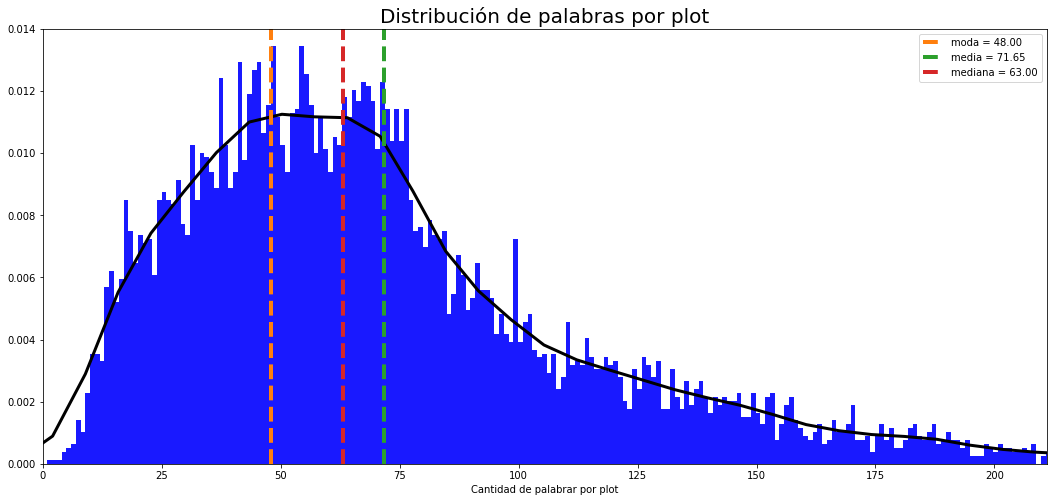

In [186]:
#Graficamos la longitud de las oraciones lematizadas en un rango de 0 a P99 y mostramos la ubicacion de la media, la mediana y la moda
fig, ax = plt.subplots(figsize=(18,8))
sb.distplot(dataTraining['all_length'], bins=dataTraining['all_length'].max(),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(dataTraining['all_length'], 99))
ax.set_xlabel('Cantidad de palabrar por plot')
ymax = 0.014
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'moda = {mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label=f'media = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'mediana = {median:.2f}', linewidth=4)
ax.set_title('Distribución de palabras por plot', fontsize=20)
plt.legend()
plt.show()

In [187]:
#Creamos los bigramas y los trigramas para calcular los pesos del layer embedding por fuera, esto para facilitar el training
bigrams = Phrases(sentences=dataT)
trigrams =  Phrases(sentences=bigrams[dataT])

In [188]:
#Obtenemos el modelo de trigramas con una longitud maxima de P99
embedding_vector_size = np.int(np.percentile(dataTraining['all_length'], 99))
trigrams_model = Word2Vec(
    sentences = trigrams[bigrams[dataT]],
    size = embedding_vector_size,
    min_count=3, window=5, workers=16)

In [189]:
#Que tan grande quedó nuestro vocabulario
print("Tamaño del vocabulario:", len(trigrams_model.wv.vocab))

Tamaño del vocabulario: 16931


In [190]:
#Creamos funcion para vectorizar finalmente las horaciones
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorizando oraciones...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda plot: list(map(keys.index, filter(filter_unknown, plot)))
    vectorized = list(map(encode, data))
    print('Vectorizando oraciones... (terminado)')
    return vectorized

print('Conviertiendo oraciones en enegramas...', end='\r')
X_data = trigrams[bigrams[dataT]]
print('Conviertiendo oraciones eh enegramas... (terminado)')
input_length = 150

#Obtenemos el pad de nuestra data
X_pad = pad_sequences(
    sequences=vectorize_data(X_data, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transformando oraciones en palabras vectorizadas... (done)')

Conviertiendo oraciones eh enegramas... (terminado)
Vectorizando oraciones...Vectorizando oraciones... (terminado)
Transformando oraciones en palabras vectorizadas... (done)


# Exercise 14.2

Create a LSTM neural network to predict the rating of a movie

Calculate the testing set accuracy

In [191]:
#Importamos TF
import tensorflow as tf
#Forzamos a que use GPU
tf.device("gpu:0")
#Accedemos a la configuración del TF
config = tf.ConfigProto()
#Habilitamos el crecimiento de memoria para evitar volcamientos por el uso de GPU Local (NVidia GTX 1660 Ti 6GB RAM DDR5)
config.gpu_options.allow_growth = True

In [192]:
#Importamos Keras (y ya no tiene necesidad de crear el TF)
import keras
from keras import backend as K

In [193]:
from keras.models import Sequential
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

In [194]:
from livelossplot import PlotLossesKeras
%matplotlib inline

In [200]:
#Partimos la data en train y test
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.1, random_state=666)

In [264]:
#Creamos el modelo con los parametros que definimos con:
#1 Capa de embedding pero nuetros pesos iniciales usamos los calculados
#2 un LSTM bidireccional de tamaño 128 y con dropout recurrente de 0.1 para evitar overfitting
#Capas de dropout para evitar overfitting
#Capa intermedia con un kernel regularizador con penalidad l2 y bias
#capa de salida con bias, 1 salida y función de activación sigmoide
def build_model(embedding_matrix: np.ndarray, input_length: int, output_size: int):
    model = Sequential(name='E14 - LSTM')
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=True))
    model.add(LSTM(256, recurrent_dropout=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(48))
    model.add(Dropout(0.4))
    model.add(Dense(output_size, activation='sigmoid'))
    model.summary()
    return model

#limpiamos el keras por si tenemos algun modelo en nuestra GPU, esto para evitar volcamientos
K.clear_session()
#Contruimos el modelo con nuestras variables predefinidas: peso del embedding, longitud de entrada, salidas(1)
model = build_model(
    embedding_matrix=trigrams_model.wv.vectors,
    input_length=input_length,
    output_size=1)

Model: "E14 - LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 211)          3572441   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               479232    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 48)                12336     
_________________________________________________________________
dropout_2 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 49        
Total params: 4,064,058
Trainable params: 4,064,058
Non-trainable params: 0
______________________________________________

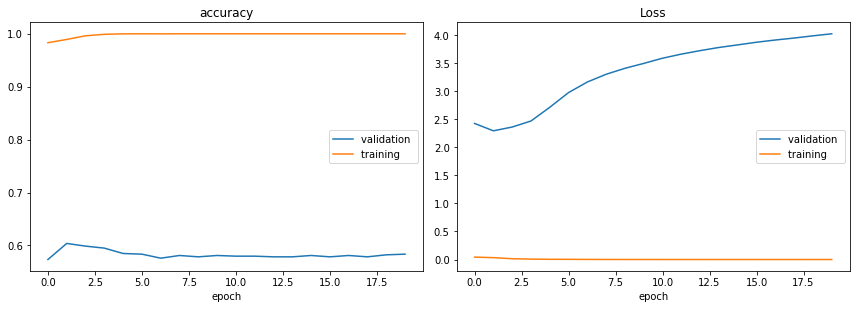

accuracy
	validation       	 (min:    0.573, max:    0.604, cur:    0.584)
	training         	 (min:    0.983, max:    1.000, cur:    1.000)
Loss
	validation       	 (min:    2.295, max:    4.025, cur:    4.025)
	training         	 (min:    0.000, max:    0.043, cur:    0.000)


In [259]:
#Compilamos y entremoas el modelo
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

history = model.fit(
    x=X_train,
    y=y_train,
    verbose=0,
    validation_data=(X_test, y_test),
    batch_size=1400,
    epochs=20,
    callbacks=[PlotLossesKeras()])

In [260]:
#Calculamos la prediccion
pred = model.predict(X_pad)


In [261]:
#Buscamos el mejor threshold que optimice la curva roc
from sklearn.metrics import roc_curve

def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1],:]

    return list(roc_t['threshold']) 

threshold = Find_Optimal_Cutoff(y,pred)
threshold

[0.5429014563560486]

In [263]:
#Calculamos el accuracy del modelo
from sklearn.metrics import accuracy_score
accuracy_score(y,(pred>threshold).astype('int'))

0.9582013932868905

## Nuestro accuracy score es de 0.958 con un threshold de 0.54, lo que indica que nuestro modelo es funcional